# ResNet_wit_SE_block
이 문서는 여러 글을 참고하여 만든 Res_SE_Net입니다.
- Residual_Block class에 Residual_block과 Residual_with_SE_block을 return 하는 method가 있습니다.
- res_with_se_block 함수는 res_se_net을 return 하는 함수입니다.

##참고
- Jie Hu, Li Shen, Samuel Albanie, Gang Sun and, Enhua Wu, "Squeeze-and-Excitaion Networks",arxiv:1709.01507[https://arxiv.org/abs/1709.01507]
- towardDataSience :Squeeze-and-Excitation Networks[https://towardsdatascience.com/squeeze-and-excitation-networks-9ef5e71eacd7]
- Image Classification with EfficientNet: Better performance with computational efficiency[https://medium.com/analytics-vidhya/image-classification-with-efficientnet-better-performance-with-computational-efficiency-f480fdb00ac6]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AHN-UIq3hUvWHsV_sY-ZM0TT-ssRIvaCHXwsTwVDAJx8IzEKYpBPAI
Mounted at /content/drive


In [ ]:
import collections

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

In [ ]:
train = pd.read_csv('/content/drive/My Drive/머신러닝 데이터/data/train.csv')
test = pd.read_csv('/content/drive/My Drive/머신러닝 데이터/data/test.csv')

In [ ]:
# Data Preprocessing

train_img = train.iloc[:,3:].to_numpy().reshape(-1,28,28,1)
train_digit = train['digit']
train_letter = train['letter']
test_img = test.iloc[:,2:].to_numpy().reshape(-1,28,28,1)
test_letter = test['letter']

In [ ]:
train_img_norm = train_img / 255.0
test_img_norm = test_img / 255.0

In [ ]:
X_train = train_img_norm
y_train = train_digit.to_numpy()

X_test = test_img_norm

In [ ]:
from sklearn.model_selection import train_test_split

X_train_data, X_val_data, y_train_data, y_val_data = train_test_split(X_train, y_train, test_size = 0.2, random_state = 1004)

In [ ]:
def loss_plot(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                ax[i].plot(epochs, y)
                ax[i].set_title('Loss')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    ax[i].plot(epochs, y)
                    ax[i].set_title('Accuracy')
                    
    plt.show()

In [ ]:
Global_params = collections.namedtuple('Global_params', [
    'activation', 'batch_norm'
])

Block_params = collections.namedtuple('Block_params', [
    'channels', 'kernel_size', 'strides', 'padding', 'se_ratio', 'block_number', 'repeat_number'
])

Block_params.__new__.__defaults__ = (None,) * len(Block_params._fields)

global_params = Global_params(activation = 'relu', batch_norm=False)

Block_params_list = [
    Block_params(channels = 128, kernel_size = (3,3), strides = 1, padding = 'same', se_ratio = 0.25, block_number=2, repeat_number=0),
    Block_params(channels = 256, kernel_size = (3,3), strides = 1, padding = 'same', se_ratio = 0.25, block_number=3, repeat_number=0),
    Block_params(channels = 256, kernel_size = (3,3), strides = 1, padding = 'same', se_ratio = 0.25, block_number=4, repeat_number=0)
]

# CLASS : Residual_Block

- out : make a residual_block
- out_with_se_block : make a residual_block with a se_block

# func : init_model
## params
- conv_2_layers
- conv_3_layers
- learning_rate
- drop_rate
- block_params_list


In [ ]:
class Residual_Block:

    def __init__(self, global_params, block_params):
        '''

        :param block_params: 'Block_params' ,the parameter of tensorflow layers
        '''
        self._activation = global_params.activation
        self._batch_norm = global_params.batch_norm

        self._se_ratio = block_params.se_ratio
        self._channels = block_params.channels
        self._kernel_size = block_params.kernel_size
        self._strides = block_params.strides
        self._padding = block_params.padding
        self._block_number = block_params.block_number
        self._repeat_number = block_params.repeat_number

    def se_block(self, input_tensor):
        x = input_tensor
        block_number = self._block_number
        repeat_number = self._repeat_number

        # squeeze phase
        x = layers.GlobalAveragePooling2D(name = 'gap{}_squeeze_{}'.format(block_number, repeat_number))(x)
        x = layers.Reshape((1, 1, -1), name = 'reshape{}_{}'.format(block_number, repeat_number))(x)

        # reduce phase
        reduced_filters = max(1, (self._channels * self._se_ratio))
        x = layers.Conv2D(reduced_filters,
                          kernel_size=(1, 1),
                          strides=1,
                          padding='same',
                          activation='relu',
                          name = 'conv{}_relu_{}'.format(block_number,repeat_number))(x)
        x = layers.Conv2D(self._channels,
                          kernel_size=(1, 1),
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          name = 'conv{}_sigmoid_{}'.format(block_number, repeat_number))(x)
        # Excitaion
        x = layers.multiply([input_tensor, x], name = 'excite{}_{}'.format(block_number, repeat_number))

        return x

    def out(self, input_tensor):
        '''

        :param input_tensor: 'tensor', input_tensor (Conv_Block)
        :return: 'tensor', output_tensor
        '''

        x = input_tensor
        block_number = self._block_number
        repeat_number = self._repeat_number

        x = layers.Conv2D(self._channels,
                          kernel_size = self._kernel_size,
                          strides = self._strides,
                          padding = self._padding,
                          activation = self._activation,
                          name = 'conv{}_res_{}_1'.format(block_number, repeat_number))(x)
        x = layers.Conv2D(self._channels,
                          kernel_size = self._kernel_size,
                          strides = self._strides,
                          padding = self._padding,
                          name = 'conv{}_res_{}_2'.format(block_number, repeat_number))(x)
        x = layers.add([input_tensor, x], name = 'add{}_{}'.format(block_number, repeat_number))
        if self._batch_norm:
            x = layers.BatchNormalization()(x)
        x = layers.Activation(self._activation, name = 'activation{}_{}'.format(block_number, repeat_number))(x)

        return x

    def out_with_se_block(self, input_tensor):
        x = input_tensor

        block_number = self._block_number
        repeat_number = self._repeat_number
        x = layers.Conv2D(self._channels,
                          kernel_size=self._kernel_size,
                          strides=self._strides,
                          padding=self._padding,
                          activation=self._activation,
                          name = 'conv{}_res_{}_1'.format(block_number, repeat_number))(x)
        x = layers.Conv2D(self._channels,
                          kernel_size=self._kernel_size,
                          strides=self._strides,
                          padding=self._padding,
                          name = 'conv{}_res_{}_2'.format(block_number, repeat_number))(x)
        x = self.se_block(x)

        x = layers.add([input_tensor, x], name = 'add{}_{}'.format(block_number, repeat_number))
        if self._batch_norm:
            x = layers.BatchNormalization()(x)
        x = layers.Activation(self._activation, name = 'activation{}_{}'.format(block_number, repeat_number))(x)

        return x

In [ ]:
def resnet_with_se(conv_2_layers, conv_3_layers, conv_4_layers,learning_rate, drop_rate, block_params_list):
    img_input = layers.Input(shape=(28, 28, 1))

    #Conv_Block_1
    conv1 = layers.Conv2D(128,
                          kernel_size = (3, 3),
                          strides = 1,
                          padding = 'same',
                          activation='relu',
                          name = 'conv1_1')(img_input)

    # Residual_Module_with_SE_Block_1
    for i in range(conv_2_layers):
        if i == 0:
            # First layer
            conv2_0 = layers.Conv2D(128,
                          kernel_size = (3, 3),
                          strides = 1,
                          padding = 'same',
                          activation='relu',
                          name = 'conv2_0')(conv1)
            args = block_params_list[0]
            args = args._replace(repeat_number = i + 1)
            conv2 = Residual_Block(global_params, args).out_with_se_block(conv2_0)
        else:
            args = args._replace(repeat_number = i + 1)
            conv2 = Residual_Block(global_params, args).out_with_se_block(conv2)

    conv2 = layers.MaxPool2D((2,2), strides = 2, name = 'pool2')(conv2)

    # Residual_Module_with_SE_Block_2
    for i in range(conv_3_layers):
        if i == 0:
            # First layer
            conv3_0 = layers.Conv2D(256,
                          kernel_size = (3, 3),
                          strides = 1,
                          padding = 'same',
                          activation='relu',
                          name = 'conv3_0')(conv2)
            args = block_params_list[1]
            args = args._replace(repeat_number=i+1)
            conv3 = Residual_Block(global_params, args).out_with_se_block(conv3_0)
        else:
            args = args._replace(repeat_number=i+1)
            conv3 = Residual_Block(global_params, args).out_with_se_block(conv3)

    conv3 = layers.MaxPool2D((2, 2), strides=2, name = 'pool3')(conv3)

    # Residual_Module_with_SE_Block_3
    for i in range(conv_4_layers):
        if i == 0:
            # First layer
            conv4_0 = layers.Conv2D(256,
                          kernel_size = (3, 3),
                          strides = 1,
                          padding = 'same',
                          activation='relu',
                          name = 'conv4_0')(conv2)
            args = block_params_list[2]
            args = args._replace(repeat_number=i+1)
            conv4 = Residual_Block(global_params, args).out_with_se_block(conv4_0)
        else:
            args = args._replace(repeat_number=i+1)
            conv4 = Residual_Block(global_params, args).out_with_se_block(conv4)

    conv4 = layers.MaxPool2D((2, 2), strides=2, name = 'pool4')(conv4)

    # FC layers
    img_features = layers.Flatten()(conv4)
    img_features = layers.Dense(512, name = 'fc_1')(img_features)
    img_features = layers.Activation('relu', name ='fc_activation_1')(img_features)
    img_features = layers.Dropout(rate=drop_rate, name = 'fc_dropout_1')(img_features)
    img_features = layers.Dense(512, name = 'fc_2')(img_features)
    img_features = layers.Activation('relu', name ='fc_activation_2')(img_features)
    img_features = layers.Dropout(rate=drop_rate, name = 'fc_dropout_2')(img_features)

    # Output layer
    digit_pred = layers.Dense(10, activation='softmax', name = 'prediction')(img_features)

    model = keras.Model(inputs=img_input, outputs=digit_pred)

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
def resnet(conv_2_layers, conv_3_layers, learning_rate, drop_rate, block_params_list):
    img_input = layers.Input(shape=(28, 28, 1))

    #Conv_Block_1
    conv1 = layers.Conv2D(128,
                          kernel_size = (3, 3),
                          strides = 1,
                          padding = 'same',
                          activation='relu',
                          name = 'conv1_1')(img_input)

    # Residual_Module_with_SE_Block_1
    for i in range(conv_2_layers):
        if i == 0:
            # First layer
            conv2_0 = layers.Conv2D(128,
                          kernel_size = (3, 3),
                          strides = 1,
                          padding = 'same',
                          activation='relu',
                          name = 'conv2_0')(conv1)
            args = block_params_list[0]
            args = args._replace(block_number = 2, repeat_number = i + 1)
            conv2 = Residual_Block(global_params, args).out(conv2_0)
        else:
            args = args._replace(repeat_number = i + 1)
            conv2 = Residual_Block(global_params, args).out(conv2)

    conv2 = layers.MaxPool2D((2,2), strides = 2, name = 'pool2')(conv2)

    # Residual_Module_with_SE_Block_2
    for i in range(conv_3_layers):
        if i == 0:
            # First layer
            conv3_0 = layers.Conv2D(256,
                          kernel_size = (3, 3),
                          strides = 1,
                          padding = 'same',
                          activation='relu',
                          name = 'conv3_0')(conv2)
            args = block_params_list[1]
            args = args._replace(block_number=3, repeat_number=i+1)
            conv3 = Residual_Block(global_params, args).out(conv3_0)
        else:
            args = args._replace(repeat_number=i+1)
            conv3 = Residual_Block(global_params, args).out(conv3)

    conv3 = layers.MaxPool2D((2, 2), strides=2, name = 'pool3')(conv3)

    # Residual_Module_with_SE_Block_3
    conv4_0 = layers.Conv2D(256,
                          kernel_size = (3, 3),
                          strides = 1,
                          padding = 'same',
                          activation='relu',
                          name = 'conv4_0')(conv3)
    args = block_params_list[2]
    args = args._replace(block_number = 4, repeat_number = 1)
    conv4 = Residual_Block(global_params, args).out(conv4_0)

    conv4 = layers.MaxPool2D((2, 2), strides=2, name = 'pool4')(conv4)

    # FC layers
    img_features = layers.Flatten()(conv4)
    img_features = layers.Dense(512, name = 'fc_1')(img_features)
    img_features = layers.Activation('relu', name ='fc_activation_1')(img_features)
    img_features = layers.Dropout(rate=drop_rate, name = 'fc_dropout_1')(img_features)
    img_features = layers.Dense(512, name = 'fc_2')(img_features)
    img_features = layers.Activation('relu', name ='fc_activation_2')(img_features)
    img_features = layers.Dropout(rate=drop_rate, name = 'fc_dropout_2')(img_features)

    # Output layer
    digit_pred = layers.Dense(10, activation='softmax', name = 'prediction')(img_features)

    model = keras.Model(inputs=img_input, outputs=digit_pred)

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Training Function


In [ ]:
def train_model_v1(model, X_train, y_train, X_val, y_val ,epochs, batch_size = None):
      
    callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 20, restore_best_weights = True)
    
    history = model.fit(x = X_train, y = y_train, epochs = epochs, batch_size = batch_size,
                       shuffle = True, validation_data = (X_val, y_val), callbacks = [callback])
    
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    
    return epochs, hist

def train_model_v2(model, X_train, y_train, X_val, y_val, epochs, batch_size = None):
    
    callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)
    
    history = model.fit(x = X_train, y = y_train, epochs = epochs, batch_size = batch_size,
                       shuffle = True, validation_data = (X_val, y_val), callbacks = [callback])
    
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    
    return epochs, hist

def train_model_v3(model, X_train, y_train, X_val, y_val, epochs, batch_size = None, validation_split = 0.1, set_seed = 1004):
      
      from tensorflow.keras.preprocessing.image import ImageDataGenerator

      callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 20, restore_best_weights = True)

      train_gen = ImageDataGenerator(width_shift_range = 2,
                                 height_shift_range = 2,
                                 rotation_range = 5,
                                 zoom_range=0.05,
                                fill_mode='nearest')

      history = model.fit(train_gen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, shuffle = True,
                          validation_data = (X_val, y_val),callbacks = [callback])

      epochs = history.epoch
      hist = pd.DataFrame(history.history)
  

      return epochs, hist

# Model Training


In [ ]:
conv2_layers = 5
conv3_layers = 5
learning_rate = 0.00001
drop_rate = 0.5

resnet_with_se_1 = resnet_with_se(conv2_layers, conv3_layers,learning_rate, drop_rate, Block_params_list)
resnet_with_se_1.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 28, 28, 128)  1280        input_3[0][0]                    
__________________________________________________________________________________________________
conv2_0 (Conv2D)                (None, 28, 28, 128)  147584      conv1_1[0][0]                    
__________________________________________________________________________________________________
conv2_res_1_1 (Conv2D)          (None, 28, 28, 128)  147584      conv2_0[0][0]                    
_______________________________________________________________________________________

Epoch 1/200
1638/1638 [==============================] - 27s 16ms/step - loss: 2.3003 - accuracy: 0.1123 - val_loss: 2.2992 - val_accuracy: 0.1341
Epoch 2/200
1638/1638 [==============================] - 26s 16ms/step - loss: 2.2936 - accuracy: 0.1270 - val_loss: 2.2855 - val_accuracy: 0.1415
Epoch 3/200
1638/1638 [==============================] - 26s 16ms/step - loss: 2.2344 - accuracy: 0.1740 - val_loss: 2.1482 - val_accuracy: 0.2317
Epoch 4/200
1638/1638 [==============================] - 26s 16ms/step - loss: 2.0911 - accuracy: 0.2302 - val_loss: 1.9937 - val_accuracy: 0.3122
Epoch 5/200
1638/1638 [==============================] - 26s 16ms/step - loss: 1.8769 - accuracy: 0.3181 - val_loss: 1.7774 - val_accuracy: 0.3829
Epoch 6/200
1638/1638 [==============================] - 26s 16ms/step - loss: 1.6740 - accuracy: 0.4182 - val_loss: 1.5569 - val_accuracy: 0.4902
Epoch 7/200
1638/1638 [==============================] - 26s 16ms/step - loss: 1.4589 - accuracy: 0.5079 - val_loss: 1

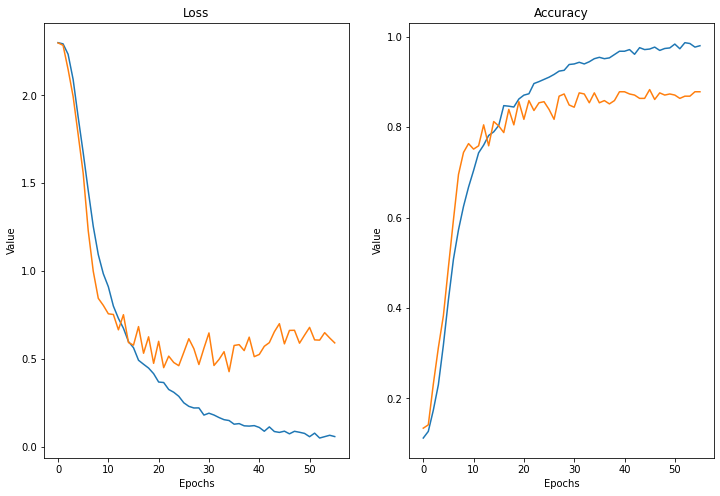

In [ ]:
## Model Test용
batch_size = 1
epochs = 200

epoch, hist = train_model_v1(resnet_with_se_1, X_train_data, y_train_data, X_val_data, y_val_data, epochs, batch_size)

list_of_metrics_to_plot = ['loss','val_loss','accuracy','val_accuracy']
loss_plot(epoch, hist, list_of_metrics_to_plot)